In [1]:
## Code adapted from algorithm in this pdf: http://www.artcompsci.org/kali/vol/plummer/volume9.pdf

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

# import miyamoto_nagai potential from galpy
from galpy.potential import MiyamotoNagaiPotential

from sklearn.neighbors import KernelDensity

print("Modules loaded :)")


Modules loaded :)


In [2]:
# Set up matplotlib settings
from matplotlib.colors import LogNorm
from mpl_toolkits.mplot3d import Axes3D
import matplotlib as mpl


plt.rcParams.update(plt.rcParamsDefault)  # Reset the default matplotlib settings

plt.rcParams['figure.figsize'] = (5, 4)  # Set the figure size (width, height) in inches

plt.rcParams['font.size'] = 18  # Set the font size for labels and titles
plt.rcParams['figure.dpi'] = 150  # Set the DPI (dots per inch) for high-resolution output
plt.rcParams['font.family'] = 'serif'  # Set the font family

plt.rcParams['axes.linewidth'] = 1.5  # Set the linewidth of the axes
plt.rcParams['axes.edgecolor'] = 'black'  # Set the color of the axes' edges
plt.rcParams['axes.spines.top'] = True  # Hide the top spine of the axes
plt.rcParams['axes.spines.right'] = True  # Hide the right spine of the axes

plt.rcParams['xtick.direction'] = 'in'  # Set the direction of x-axis ticks to inward
plt.rcParams['xtick.major.size'] = 4  # Set the size of major x-axis ticks
plt.rcParams['xtick.major.width'] = 1.2  # Set the width of major x-axis ticks
plt.rcParams['xtick.minor.size'] = 2  # Set the size of minor x-axis ticks
plt.rcParams['xtick.minor.width'] = 1.0  # Set the width of minor x-axis ticks

plt.rcParams['ytick.direction'] = 'in'  # Set the direction of y-axis ticks to inward
plt.rcParams['ytick.right'] = True  # Show the y-ticks on the right axis
plt.rcParams['ytick.major.size'] = 4  # Set the size of major y-axis ticks
plt.rcParams['ytick.major.width'] = 1.2  # Set the width of major y-axis ticks
plt.rcParams['ytick.minor.size'] = 2  # Set the size of minor y-axis ticks
plt.rcParams['ytick.minor.width'] = 1.0  # Set the width of minor y-axis ticks

plt.rcParams['lines.linewidth'] = 1.5  # Set the linewidth of the plotted lines
plt.rcParams['legend.frameon'] = False  # Hide the frame of the legend
plt.rcParams['legend.fontsize'] = 14  # Set the font size of the legend

# ... Additional settings as needed ...

# FOR LATEX FONT, CMU SERIF
#mpl.rcParams['font.family'] = 'serif'
#mpl.rcParams['font.serif'] = 'CMU Serif'
#mpl.rcParams['font.sans-serif'] = 'CMU Sans Serif, DejaVu Sans, Bitstream Vera Sans, Lucida Grande, Verdana, Geneva, Lucid, Arial, Helvetica, Avant Garde, sans-serif'
mpl.rcParams['text.usetex'] = True


## Visualising the Plummer Sphere

In [3]:

def mkplummer_vectorised(n, seed=0):
    if seed == 0:
        np.random.seed()
    else:
        np.random.seed(seed)

    bodies = np.zeros((n, 7))  # Each row: mass, x, y, z, vx, vy, vz
    bodies[:, 0] = 1.0 / n

    # Generate positions
    radius = 1.0 / np.sqrt(np.random.rand(n) ** (-2.0 / 3.0) - 1.0)
    theta = np.arccos(np.random.uniform(-1, 1, n))
    phi = np.random.uniform(0, 2 * np.pi, n)
    bodies[:, 1] = radius * np.sin(theta) * np.cos(phi)
    bodies[:, 2] = radius * np.sin(theta) * np.sin(phi)
    bodies[:, 3] = radius * np.cos(theta)

    # Generate velocities
    x = np.random.rand(n)
    y = np.random.rand(n) * 0.1
    mask = y > x * x * (1.0 - x * x)**3.5
    while np.any(mask):
        x[mask] = np.random.rand(np.sum(mask))
        y[mask] = np.random.rand(np.sum(mask)) * 0.1
        mask = y > x * x * (1.0 - x * x)**3.5

    velocity = x * np.sqrt(2.0) * (1.0 + radius * radius) ** (-0.25)
    theta = np.arccos(np.random.uniform(-1, 1, n))
    phi = np.random.uniform(0, 2 * np.pi, n)
    bodies[:, 4] = velocity * np.sin(theta) * np.cos(phi)
    bodies[:, 5] = velocity * np.sin(theta) * np.sin(phi)
    bodies[:, 6] = velocity * np.cos(theta)

    return bodies

def janky_stream(n,R,phimax,v,seed=0, rstd=0.01, thetastd=0.01, vstd=0.01):
    np.random.seed(seed)

    bodies = np.zeros((n, 7))  # Each row: mass, x, y, z, vx, vy, vz
    bodies[:, 0] = 1.0 / n

    ## Generate positions
    # select phi between 0 and phimax
    phi = np.random.uniform(0, phimax, n)
    # select R as a gaussian with mean R and std of rstd, same for theta
    R = np.random.normal(R, rstd, n)
    theta = np.random.normal(np.pi/2., thetastd, n)

    bodies[:, 1] = R * np.sin(theta) * np.cos(phi)
    bodies[:, 2] = R * np.sin(theta) * np.sin(phi)
    bodies[:, 3] = R * np.cos(theta)

    ## generate velocities
    # select v as a gaussian with mean v and std of 0.01
    v = np.random.normal(v, vstd, n)
    # all the direction should be the same and circular
    bodies[:, 4] = v * np.sin(theta) * np.sin(phi)
    bodies[:, 5] = v * np.sin(theta) * np.cos(phi)
    bodies[:, 6] = v * np.cos(theta)

    return bodies

def plummer_and_stream(n, fraction_stream, R=10.0, phimax=np.pi/4, seed=0, rstd=0.01, thetastd=0.01, vstd=0.01):
    if fraction_stream == 0:
        return mkplummer_vectorised(n, seed=seed)
    n_stream = int(n*fraction_stream)
    n_plummer = n - n_stream
    bodies = mkplummer_vectorised(n_plummer, seed=seed)
    # the velocity of the stream is the circular velocity at R
    v = np.sqrt((1.-fraction_stream)*(np.sqrt( R**2 * (R**2 + 1.)**(-3./2.) )))
    print(v)
    bodies_stream = janky_stream(n_stream, R,phimax,v,seed=seed, rstd=rstd, thetastd=thetastd, vstd=vstd)
    return np.vstack((bodies, bodies_stream))



In [4]:
## Generate a plummer and stream distribution in x-y plane and plot it
n = 1000000
seed = 1
#fraction_stream = 1.0e-3
fraction_stream = 0.0

bodies = plummer_and_stream(n, fraction_stream, seed=seed)

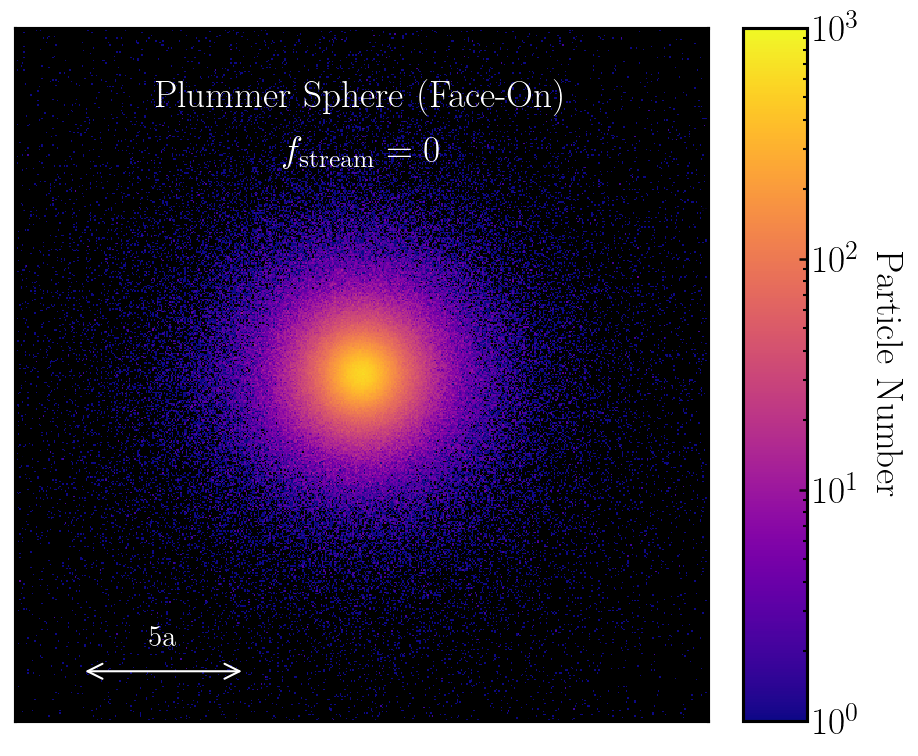

In [112]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import numpy as np
import matplotlib.gridspec as gridspec

rmax = 10.5
nbins = 500
bins = [np.linspace(-rmax, rmax, nbins), np.linspace(-rmax, rmax, nbins)]

# Create a figure with gridspec layout
fig = plt.figure(figsize=(8, 6))  # Increase the width a bit for the colorbar
gs = gridspec.GridSpec(1, 2, width_ratios=[15, 1], wspace=-0.2)  # Set the width ratios for plot and colorbar

# Main plot (on the left)
ax = fig.add_subplot(gs[0])
hist = ax.hist2d(bodies[:, 1], bodies[:, 2], bins=bins, norm=LogNorm(vmin=1, vmax=1000), cmap='plasma')
ax.set_aspect('equal')

ax.set_facecolor('black')

# turn of tick labels
ax.set_xticklabels([])
ax.set_yticklabels([])

# add title to upper part of plot with white text
# Add title to the upper part of the plot with white text, centered at the top
ax.text(0.5, 0.9, rf'Plummer Sphere (Face-On)', color='white', 
        ha='center', va='center', transform=ax.transAxes)

ax.text(0.5, 0.82, r'$f_{\rm stream}=0$', color='white', 
        ha='center', va='center', transform=ax.transAxes)

# --- Add the scale bar ---
# Assuming that 1 corresponds to a distance in the data (adjust the x-coordinate based on your data range)
scale_bar_length = 5
scale_bar_x = -8.5  # Start position of the scale bar on the x-axis
scale_bar_y = -9 # Y-coordinate to place the scale bar below the plot

# Draw the scale bar (horizontal line)
#ax.hlines(y=scale_bar_y, xmin=scale_bar_x, xmax=scale_bar_x + scale_bar_length, color='white', linewidth=2)

# Draw the double-headed arrow
ax.annotate(
    '',  # No text for the annotation, just an arrow
    xy=(scale_bar_x + scale_bar_length, scale_bar_y),  # End of the arrow
    xytext=(scale_bar_x, scale_bar_y),  # Start of the arrow
    arrowprops=dict(arrowstyle='<->', color='white', lw=1)  # Double arrow style
)

# Label the scale bar
ax.text(scale_bar_x + scale_bar_length / 2, scale_bar_y + 1.0, '5a', color='white', 
        ha='center', va='center', fontsize=14, transform=ax.transData)


"""
# Set axes and figure background to black and labels/ticks/outlines to white

fig.patch.set_facecolor('black')

# Set ticks and labels to white for visibility
ax.tick_params(colors='white')
ax.xaxis.label.set_color('white')
ax.yaxis.label.set_color('white')

# Set the color of the plot border/spine to white
for spine in ax.spines.values():
    spine.set_edgecolor('white')
"""
# Add the colorbar to a separate axis (on the right)
cax = fig.add_subplot(gs[1])
cbar = plt.colorbar(hist[3], cax=cax)
cbar.set_label('Particle Number', color='k',rotation=270,labelpad=20)
"""cbar.ax.yaxis.set_tick_params(color='white')
cbar.ax.yaxis.set_tick_params(which='both', color='white')
cbar.outline.set_edgecolor('white')  # Set colorbar outline to white
"""
# Set the colorbar ticks and labels to white
#plt.setp(plt.getp(cbar.ax.axes, 'yticklabels'), color='white')

plt.show()


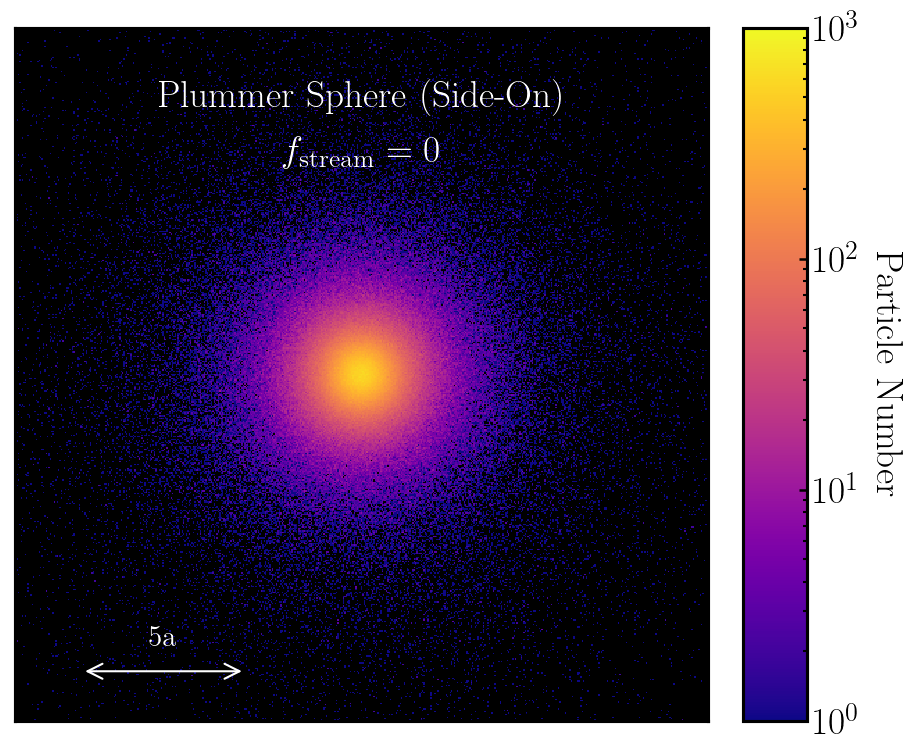

In [81]:

rmax = 10.5
nbins = 500
bins = [np.linspace(-rmax, rmax, nbins), np.linspace(-rmax, rmax, nbins)]

# Create a figure with gridspec layout
fig = plt.figure(figsize=(8, 6))  # Increase the width a bit for the colorbar
gs = gridspec.GridSpec(1, 2, width_ratios=[15, 1], wspace=-0.2)  # Set the width ratios for plot and colorbar

# Main plot (on the left)
ax = fig.add_subplot(gs[0])
hist = ax.hist2d(bodies[:, 1], bodies[:, 3], bins=bins, norm=LogNorm(vmin=1, vmax=1000), cmap='plasma')
ax.set_aspect('equal')

ax.set_facecolor('black')

# turn of tick labels
ax.set_xticklabels([])
ax.set_yticklabels([])

# add title to upper part of plot with white text
# Add title to the upper part of the plot with white text, centered at the top
ax.text(0.5, 0.9, rf'Plummer Sphere (Side-On)', color='white', 
        ha='center', va='center', transform=ax.transAxes)

ax.text(0.5, 0.82, r'$f_{\rm stream}=0$', color='white', 
        ha='center', va='center', transform=ax.transAxes)

# --- Add the scale bar ---
# Assuming that 1 corresponds to a distance in the data (adjust the x-coordinate based on your data range)
scale_bar_length = 5
scale_bar_x = -8.5  # Start position of the scale bar on the x-axis
scale_bar_y = -9 # Y-coordinate to place the scale bar below the plot

# Draw the scale bar (horizontal line)
#ax.hlines(y=scale_bar_y, xmin=scale_bar_x, xmax=scale_bar_x + scale_bar_length, color='white', linewidth=2)

# Draw the double-headed arrow
ax.annotate(
    '',  # No text for the annotation, just an arrow
    xy=(scale_bar_x + scale_bar_length, scale_bar_y),  # End of the arrow
    xytext=(scale_bar_x, scale_bar_y),  # Start of the arrow
    arrowprops=dict(arrowstyle='<->', color='white', lw=1)  # Double arrow style
)

# Label the scale bar
ax.text(scale_bar_x + scale_bar_length / 2, scale_bar_y + 1.0, '5a', color='white', 
        ha='center', va='center', fontsize=14, transform=ax.transData)


"""
# Set axes and figure background to black and labels/ticks/outlines to white

fig.patch.set_facecolor('black')

# Set ticks and labels to white for visibility
ax.tick_params(colors='white')
ax.xaxis.label.set_color('white')
ax.yaxis.label.set_color('white')

# Set the color of the plot border/spine to white
for spine in ax.spines.values():
    spine.set_edgecolor('white')
"""
# Add the colorbar to a separate axis (on the right)
cax = fig.add_subplot(gs[1])
cbar = plt.colorbar(hist[3], cax=cax)
cbar.set_label('Particle Number', color='k',rotation=270,labelpad=20)
"""cbar.ax.yaxis.set_tick_params(color='white')
cbar.ax.yaxis.set_tick_params(which='both', color='white')
cbar.outline.set_edgecolor('white')  # Set colorbar outline to white
"""
# Set the colorbar ticks and labels to white
#plt.setp(plt.getp(cbar.ax.axes, 'yticklabels'), color='white')

plt.show()


## Visualising the Miyamoto-Nagai Disk

In [4]:

def janky_stream(n,R,phimax,v,seed=0, rstd=0.01, thetastd=0.01, vstd=0.01):
    np.random.seed(seed)

    bodies = np.zeros((n, 7))  # Each row: mass, x, y, z, vx, vy, vz
    bodies[:, 0] = 1.0 / n

    ## Generate positions
    # select phi between 0 and phimax
    phi = np.random.uniform(0, phimax, n)
    # select R as a gaussian with mean R and std of rstd, same for theta
    R = np.random.normal(R, rstd, n)
    theta = np.random.normal(np.pi/2., thetastd, n)

    bodies[:, 1] = R * np.sin(theta) * np.cos(phi)
    bodies[:, 2] = R * np.sin(theta) * np.sin(phi)
    bodies[:, 3] = R * np.cos(theta)

    ## generate velocities
    # select v as a gaussian with mean v and std of 0.01
    v = np.random.normal(v, vstd, n)
    # all the direction should be the same and circular
    bodies[:, 4] = v * np.sin(theta) * np.sin(phi)
    bodies[:, 5] = v * np.sin(theta) * np.cos(phi)
    bodies[:, 6] = v * np.cos(theta)

    return bodies

def disk_and_stream(disk_bodies, fraction_stream, R=10.0, phimax=np.pi/4, seed=0, rstd=0.01, thetastd=0.01, vstd=0.01):
    if fraction_stream == 0:
        return disk_bodies
    n = len(disk_bodies)
    n_stream = int(n*fraction_stream)
    n_disk = n - n_stream

    bodies = disk_bodies[:n_disk]
    # the velocity of the stream is the circular velocity at R
    # initialise the Miyaamoto-Nagai potential
    MN = MiyamotoNagaiPotential(a=1.0, b=0.1, normalize=1)
    v = MN.vcirc(R)
    #v = np.sqrt((1.-fraction_stream)*(np.sqrt( R**2 * (R**2 + 1.)**(-3./2.) )))
    print(v)
    bodies_stream = janky_stream(n_stream, R,phimax,v,seed=seed, rstd=rstd, thetastd=thetastd, vstd=vstd)
    return np.vstack((bodies, bodies_stream))

In [5]:
## loading the MN disk bodies and adding a given stream fraction

MN_combined_bodies = np.load('MN_bodies.npy')
fraction_stream = 0.0

bodies = disk_and_stream(MN_combined_bodies[:1000000], fraction_stream)


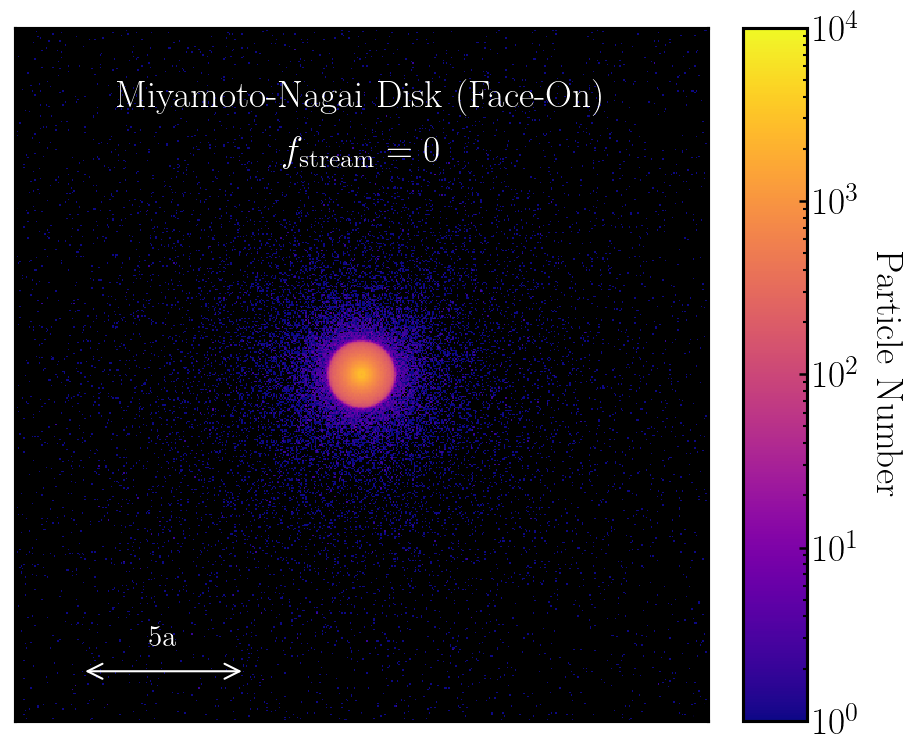

In [115]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import numpy as np
import matplotlib.gridspec as gridspec

rmax = 10.5
nbins = 500
bins = [np.linspace(-rmax, rmax, nbins), np.linspace(-rmax, rmax, nbins)]

# Create a figure with gridspec layout
fig = plt.figure(figsize=(8, 6))  # Increase the width a bit for the colorbar
gs = gridspec.GridSpec(1, 2, width_ratios=[15, 1], wspace=-0.2)  # Set the width ratios for plot and colorbar

# Main plot (on the left)
ax = fig.add_subplot(gs[0])
hist = ax.hist2d(bodies[:, 1], bodies[:, 2], bins=bins, norm=LogNorm(vmin=1, vmax=10000), cmap='plasma')
ax.set_aspect('equal')

ax.set_facecolor('black')

# turn of tick labels
ax.set_xticklabels([])
ax.set_yticklabels([])

# add title to upper part of plot with white text
# Add title to the upper part of the plot with white text, centered at the top
ax.text(0.5, 0.9, rf'Miyamoto-Nagai Disk (Face-On)', color='white', 
        ha='center', va='center', transform=ax.transAxes)

ax.text(0.5, 0.82, r'$f_{\rm stream}=0$', color='white', 
        ha='center', va='center', transform=ax.transAxes)

# --- Add the scale bar ---
# Assuming that 1 corresponds to a distance in the data (adjust the x-coordinate based on your data range)
scale_bar_length = 5
scale_bar_x = -8.5  # Start position of the scale bar on the x-axis
scale_bar_y = -9 # Y-coordinate to place the scale bar below the plot

# Draw the scale bar (horizontal line)
#ax.hlines(y=scale_bar_y, xmin=scale_bar_x, xmax=scale_bar_x + scale_bar_length, color='white', linewidth=2)

# Draw the double-headed arrow
ax.annotate(
    '',  # No text for the annotation, just an arrow
    xy=(scale_bar_x + scale_bar_length, scale_bar_y),  # End of the arrow
    xytext=(scale_bar_x, scale_bar_y),  # Start of the arrow
    arrowprops=dict(arrowstyle='<->', color='white', lw=1)  # Double arrow style
)

# Label the scale bar
ax.text(scale_bar_x + scale_bar_length / 2, scale_bar_y + 1.0, '5a', color='white', 
        ha='center', va='center', fontsize=14, transform=ax.transData)


"""
# Set axes and figure background to black and labels/ticks/outlines to white

fig.patch.set_facecolor('black')

# Set ticks and labels to white for visibility
ax.tick_params(colors='white')
ax.xaxis.label.set_color('white')
ax.yaxis.label.set_color('white')

# Set the color of the plot border/spine to white
for spine in ax.spines.values():
    spine.set_edgecolor('white')
"""
# Add the colorbar to a separate axis (on the right)
cax = fig.add_subplot(gs[1])
cbar = plt.colorbar(hist[3], cax=cax)
cbar.set_label('Particle Number', color='k',rotation=270,labelpad=20)
"""cbar.ax.yaxis.set_tick_params(color='white')
cbar.ax.yaxis.set_tick_params(which='both', color='white')
cbar.outline.set_edgecolor('white')  # Set colorbar outline to white
"""
# Set the colorbar ticks and labels to white
#plt.setp(plt.getp(cbar.ax.axes, 'yticklabels'), color='white')

plt.show()


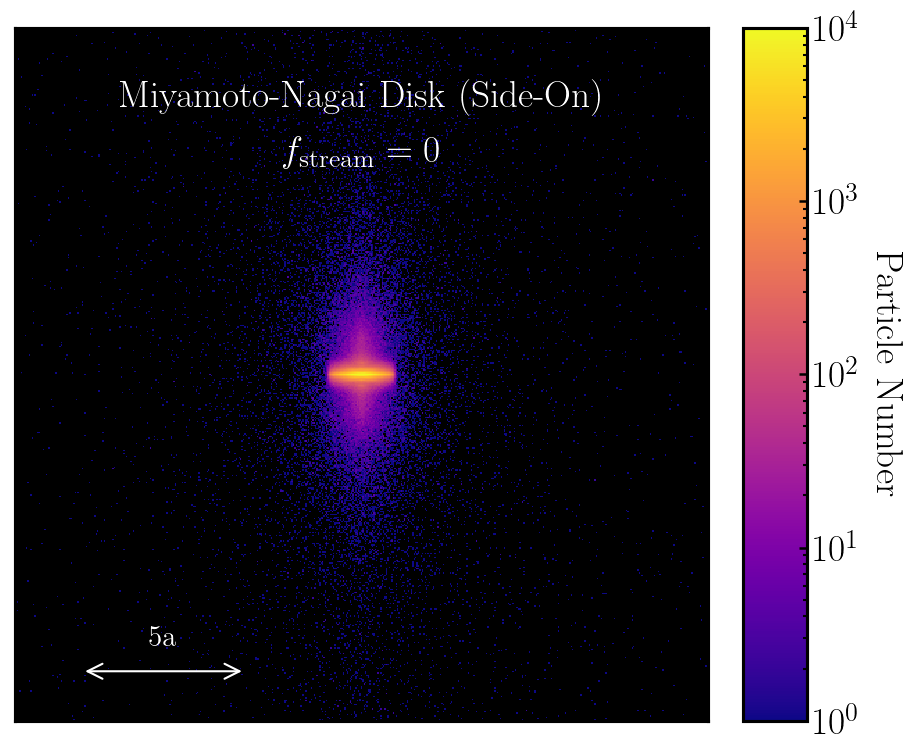

In [116]:

rmax = 10.5
nbins = 500
bins = [np.linspace(-rmax, rmax, nbins), np.linspace(-rmax, rmax, nbins)]

# Create a figure with gridspec layout
fig = plt.figure(figsize=(8, 6))  # Increase the width a bit for the colorbar
gs = gridspec.GridSpec(1, 2, width_ratios=[15, 1], wspace=-0.2)  # Set the width ratios for plot and colorbar

# Main plot (on the left)
ax = fig.add_subplot(gs[0])
hist = ax.hist2d(bodies[:, 1], bodies[:, 3], bins=bins, norm=LogNorm(vmin=1, vmax=10000), cmap='plasma')
ax.set_aspect('equal')

ax.set_facecolor('black')

# turn of tick labels
ax.set_xticklabels([])
ax.set_yticklabels([])

# add title to upper part of plot with white text
# Add title to the upper part of the plot with white text, centered at the top
ax.text(0.5, 0.9, rf'Miyamoto-Nagai Disk (Side-On)', color='white', 
        ha='center', va='center', transform=ax.transAxes)

ax.text(0.5, 0.82, r'$f_{\rm stream}=0$', color='white', 
        ha='center', va='center', transform=ax.transAxes)

# --- Add the scale bar ---
# Assuming that 1 corresponds to a distance in the data (adjust the x-coordinate based on your data range)
scale_bar_length = 5
scale_bar_x = -8.5  # Start position of the scale bar on the x-axis
scale_bar_y = -9 # Y-coordinate to place the scale bar below the plot

# Draw the scale bar (horizontal line)
#ax.hlines(y=scale_bar_y, xmin=scale_bar_x, xmax=scale_bar_x + scale_bar_length, color='white', linewidth=2)

# Draw the double-headed arrow
ax.annotate(
    '',  # No text for the annotation, just an arrow
    xy=(scale_bar_x + scale_bar_length, scale_bar_y),  # End of the arrow
    xytext=(scale_bar_x, scale_bar_y),  # Start of the arrow
    arrowprops=dict(arrowstyle='<->', color='white', lw=1)  # Double arrow style
)

# Label the scale bar
ax.text(scale_bar_x + scale_bar_length / 2, scale_bar_y + 1.0, '5a', color='white', 
        ha='center', va='center', fontsize=14, transform=ax.transData)


"""
# Set axes and figure background to black and labels/ticks/outlines to white

fig.patch.set_facecolor('black')

# Set ticks and labels to white for visibility
ax.tick_params(colors='white')
ax.xaxis.label.set_color('white')
ax.yaxis.label.set_color('white')

# Set the color of the plot border/spine to white
for spine in ax.spines.values():
    spine.set_edgecolor('white')
"""
# Add the colorbar to a separate axis (on the right)
cax = fig.add_subplot(gs[1])
cbar = plt.colorbar(hist[3], cax=cax)
cbar.set_label('Particle Number', color='k',rotation=270,labelpad=20)
"""cbar.ax.yaxis.set_tick_params(color='white')
cbar.ax.yaxis.set_tick_params(which='both', color='white')
cbar.outline.set_edgecolor('white')  # Set colorbar outline to white
"""
# Set the colorbar ticks and labels to white
#plt.setp(plt.getp(cbar.ax.axes, 'yticklabels'), color='white')

plt.show()


## KL Divergence Calculation for the Plummer Sphere

In [54]:
# Example data: particles in Cartesian coordinates (6D phase space: x, y, z, vx, vy, vz)

"""# base distribution
n = 30000
seed = 1
#fraction_stream = 1.0e-3
fraction_stream = 0.0
data_base = plummer_and_stream(n, 0.0, seed=seed)
data_perturbed = plummer_and_stream(n, 0.1, seed=seed)

# Fit KDE for the base distribution
kde_base = KernelDensity(bandwidth=1.0).fit(data_base)

# Fit KDE for the perturbed distribution
kde_perturbed = KernelDensity(bandwidth=1.0).fit(data_perturbed)

# Evaluate the log density of the perturbed samples under both KDEs
log_density_perturbed = kde_perturbed.score_samples(data_perturbed)
log_density_base = kde_base.score_samples(data_perturbed)

# Compute the KL divergence
kl_divergence = np.mean(log_density_perturbed - log_density_base)

print(f"KL Divergence: {kl_divergence}")"""


'# base distribution\nn = 30000\nseed = 1\n#fraction_stream = 1.0e-3\nfraction_stream = 0.0\ndata_base = plummer_and_stream(n, 0.0, seed=seed)\ndata_perturbed = plummer_and_stream(n, 0.1, seed=seed)\n\n# Fit KDE for the base distribution\nkde_base = KernelDensity(bandwidth=1.0).fit(data_base)\n\n# Fit KDE for the perturbed distribution\nkde_perturbed = KernelDensity(bandwidth=1.0).fit(data_perturbed)\n\n# Evaluate the log density of the perturbed samples under both KDEs\nlog_density_perturbed = kde_perturbed.score_samples(data_perturbed)\nlog_density_base = kde_base.score_samples(data_perturbed)\n\n# Compute the KL divergence\nkl_divergence = np.mean(log_density_perturbed - log_density_base)\n\nprint(f"KL Divergence: {kl_divergence}")'

In [10]:
import numpy as np
from sklearn.neighbors import NearestNeighbors

def knn_kl_divergence(Q, P, k=5):
    """
    Estimate the KL divergence D_KL(P || Q) using k-nearest neighbors.

    Parameters:
    - Q: reference distribution (samples from the base distribution)
    - P: target distribution (samples from the perturbed distribution)
    - k: number of nearest neighbors to consider

    Returns:
    - KL divergence estimate D_KL(P || Q)
    """
    N = P.shape[0]  # Number of samples in P (target distribution)
    M = Q.shape[0]  # Number of samples in Q (reference distribution)
    d = P.shape[1]  # Dimensionality of the data

    # Fit Nearest Neighbors models for both distributions
    nn_P = NearestNeighbors(n_neighbors=k).fit(P)
    nn_Q = NearestNeighbors(n_neighbors=k).fit(Q)

    # Find the k-th nearest neighbors in P (from P)
    distances_P, _ = nn_P.kneighbors(P)
    r_k = distances_P[:, -1]  # k-th nearest distance within P

    # Find the k-th nearest neighbors in Q (from P)
    distances_Q, _ = nn_Q.kneighbors(P)
    s_k = distances_Q[:, -1]  # k-th nearest distance from P to Q

    # Compute KL divergence using the nearest-neighbor distances
    kl_divergence = d / N * np.sum(np.log(s_k / r_k)) + np.log(M / (N - 1))

    return kl_divergence

# Example usage
n = 1000000
seed = 1
#fraction_stream = 1.0e-3
fraction_stream = 0.0001
data_base = plummer_and_stream(n, 0.0, seed=seed)[:,1:]
data_perturbed = plummer_and_stream(n, fraction_stream, seed=seed)[:,1:]
print(data_base.shape,data_perturbed.shape)

#for k in range(2,11):
#    kl_div = knn_kl_divergence(data_base, data_base, k=k)
#    print(f"KL Divergence (k-NN, k={k}): {kl_div}")
kl_div = knn_kl_divergence(data_base, data_perturbed, k=8)
print(f"KL Divergence (k-NN): {kl_div}")


0.5602189162216386
(1000000, 6) (1000000, 6)
KL Divergence (k-NN): 0.1482189867994727


## KL Divergence of the Disk

In [14]:
# Example usage
n = 1000000
seed = 1
#fraction_stream = 1.0e-3
MN_combined_bodies = np.load('MN_bodies.npy')
fraction_stream = 0.01

data_base = disk_and_stream(MN_combined_bodies[:n], 0.0, seed=seed)[:,1:]
data_perturbed = disk_and_stream(MN_combined_bodies[:n], fraction_stream, seed=seed)[:,1:]
print(data_base.shape,data_perturbed.shape)

#for k in range(2,11):
#    kl_div = knn_kl_divergence(data_base, data_perturbed, k=k)
#    print(f"KL Divergence (k-NN, k={k}): {kl_div}")
kl_div = knn_kl_divergence(data_base, data_perturbed, k=8)
print(f"KL Divergence (k-NN): {kl_div}")

0.5680370150689836
(1000000, 6) (1000000, 6)
KL Divergence (k-NN): 0.24133766784854313


## KL Divergence between the Disk and the Plummer

In [15]:
n = 1000000
seed = 1
data_base = plummer_and_stream(n, 0.0, seed=seed)[:,1:]
MN_combined_bodies = np.load('MN_bodies.npy')
data_perturbed = disk_and_stream(MN_combined_bodies[:n], 0.0, seed=seed)[:,1:]

print(data_base.shape,data_perturbed.shape)

#for k in range(2,11):
#    kl_div = knn_kl_divergence(data_base, data_base, k=k)
#    print(f"KL Divergence (k-NN, k={k}): {kl_div}")
kl_div = knn_kl_divergence(data_base, data_perturbed, k=8)
print(f"KL Divergence (k-NN): {kl_div}")


(1000000, 6) (1000000, 6)
KL Divergence (k-NN): 8.155473879620294
